In [56]:
from src.callbacks import *
from src.review import *
from src.utils import split_train_test, fit_predict
from sklearn.metrics import classification_report as report
import pandas as pd
import json
import os
from config import *
import matplotlib.pyplot as plt

In [29]:
from pandas.core.common import SettingWithCopyWarning
from pandas.errors import DtypeWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DtypeWarning)

In [3]:
%matplotlib inline
import fastplot
from cycler import cycler

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

default_cc = (cycler('color',['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))

In [30]:
with open(f'{DATA}/services/services.json', 'r') as file:
    services = json.loads(file.read())

In [32]:
# Load the last-day unfiltered
df1 = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
df30 = pd.read_csv(f'{DATASETS}/darknet.csv.gz')

,ip
pp,
23/TCP,16102
445/TCP,4274
5555/TCP,1522


In [ ]:
(df1.value_counts('pp')/df1.shape[0]*100).values[:3]

In [46]:
ip1 = df1.ip.unique().shape[0]
ip30 = df30.ip.unique().shape[0]

pkts1 = df1.shape[0]
pkts30 = df30.shape[0]

port1 = df1.port.unique().shape[0]
port30 = df30.port.unique().shape[0]

top3_1 = df1.value_counts('pp').index[:3]
top3_30 = df30.value_counts('pp').index[:3]

top3pkts1 = (df1.value_counts('pp')/df1.shape[0]*100).values[:3]
top3pkts30 = (df30.value_counts('pp')/df30.shape[0]*100).values[:3]

In [68]:
df1[df1.pp.isin(top3_1)].groupby('pp').agg({'ip':lambda x: len(set(x))})

,ip
pp,
23/TCP,16102
445/TCP,4274
5555/TCP,1522


In [69]:
df30[df30.pp.isin(top3_30)].groupby('pp').agg({'ip':lambda x: len(set(x))})

,ip
pp,
23/TCP,209396
445/TCP,73665
5555/TCP,20844


In [63]:
print('Date ($YYYY-MM-DD$):')
print(f'\tLast Day: 2021-03-31')
print(f'\tFull Dataset: [2021-03-02, 2021-03-31]')

print('Sources:')
print(f'\tLast Day: {ip1}')
print(f'\tFull Dataset: {ip30}')

print('Packets:')
print(f'\tLast Day: {pkts1}')
print(f'\tFull Dataset: {pkts30}')

print('Ports:')
print(f'\tLast Day: {port1}')
print(f'\tFull Dataset: {port30}')

print('Top-3 ports (\% of traffic):')
print(f'\tLast Day: {top3_1[0]} ({round(top3pkts1[0], 2)}\%), {top3_1[1]} ({round(top3pkts1[1], 2)}\%),{top3_1[2]} ({round(top3pkts1[2], 2)}\%)')
print(f'\tFull Dataset: {top3_30[0]} ({round(top3pkts30[0], 2)}\%), {top3_30[1]} ({round(top3pkts30[1], 2)}\%),{top3_30[2]} ({round(top3pkts30[2], 2)}\%)')

Days ($YYYY-MM-DD$):
	Last Day: 2021-03-31
	Full Dataset: [2021-03-02, 2021-03-31]
Sources:
	Last Day: 43118
	Full Dataset: 543900
Packets:
	Last Day: 3461220
	Full Dataset: 63562427
Ports:
	Last Day: 19583
	Full Dataset: 65537
Top-3 ports (\% of traffic):
	Last Day: 445/TCP (8.33\%), 5555/TCP (8.15\%),23/TCP (3.54\%)
	Full Dataset: 5555/TCP (7.43\%), 445/TCP (7.09\%),23/TCP (4.07\%)


## <b>Scatterplot IPs/Ports</b>

In [25]:
with open(f'{DATA}/services/services.json', 'r') as file:
    services = json.loads(file.read())

In [26]:
# Load the last-day unfiltered
df = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
# Load the filters
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())
# Apply the 30 days filter
df = df[df.ip.isin(set(filters['d1_f30']))]
df = df[['ip','port', 'class', 'pp']].drop_duplicates()
# Convert poirt/procol pairs to lowercase
df.pp = df.pp.apply(lambda x: x.lower())
# Get the class of services
df['serv'] = df.pp.apply(lambda x: convert_pp(x, services))
df = df.drop(columns=['pp'])
df_base = df.copy()

# Init IP tokens
ip_tokens = {val:tkn for (tkn,val) in enumerate(df.ip.unique())}
# Init ports tokens sorted by Service
df = df_base.sort_values('serv', ascending=False)
p_tokens = {val:tkn for (tkn,val) in enumerate(df.port.unique())}

# # Tokenize
df_base['port_token'] = df.port.apply(lambda x: p_tokens[x])
df_base['ip_token'] = df.ip.apply(lambda x: ip_tokens[x])
df = df_base.drop(columns=['port', 'ip'])

df.head()

,class,serv,port_token,ip_token
0,unknown,unk_usr,0,0
4,unknown,unk_usr,6186,1
6,unknown,unk_usr,14028,2
8,unknown,unk_usr,57,3
10,stretchoid,unk_sys,15656,4


<Figure size 640x480 with 0 Axes>

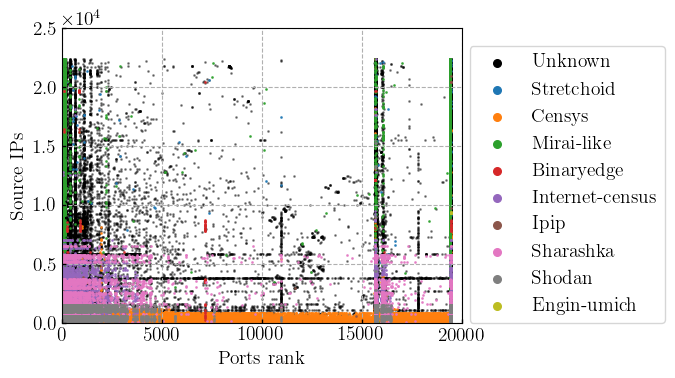

In [27]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: scatterplot_ip_ports(plt, df),
                     style='latex', figsize=(7, 4), fontsize=14, cycler=default_cc)
plot.savefig('scatterplot_gt.png')
plot.show()

In [7]:
df = df_base.copy()
p_tokens = {val:tkn for (tkn,val) in enumerate(df.port.unique())}
ip_tokens = {val:tkn for (tkn,val) in enumerate(df.ip.unique())}
df['port_token'] = df.port.apply(lambda x: p_tokens[x])
df['ip_token'] = df.ip.apply(lambda x: ip_tokens[x])
df = df.drop(columns=['port', 'ip'])

df.head()

,class,serv,port_token,ip_token
0,unknown,unk_usr,0,0
4,unknown,unk_usr,1,1
6,unknown,unk_usr,2,2
8,unknown,unk_usr,3,3
10,stretchoid,unk_sys,4,4


## <b>Heatmap Ground Truth/Service</b>

Number of packets of each Ground Truth class per Service.

In [8]:
with open(f'{DATA}/services/services.json', 'r') as file:
    services = json.loads(file.read())

In [9]:
# Load the last-day unfiltered
df = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
# Load the filters
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())
# Apply the 30 days filter
df = df[df.ip.isin(set(filters['d1_f30']))]
#df = df[['ip','port', 'class', 'pp']].drop_duplicates()
# Convert poirt/procol pairs to lowercase
df.pp = df.pp.apply(lambda x: x.lower())
# Get the class of services
df['serv'] = df.pp.apply(lambda x: convert_pp(x, services))
df = df.drop(columns=['pp'])
# Add a ones column for packets sum
df['pkts'] = 1

df.head()

,ts,ip,port,proto,class,serv,pkts
0,2021-03-31 08:29:08.449076,192.3.136.75,1970,TCP,unknown,unk_usr,1
1,2021-03-31 08:29:08.449088,192.3.136.75,1970,TCP,unknown,unk_usr,1
2,2021-03-31 08:29:08.451478,192.3.136.75,1970,TCP,unknown,unk_usr,1
3,2021-03-31 08:29:08.451491,192.3.136.75,1970,TCP,unknown,unk_usr,1
4,2021-03-31 08:29:08.459322,172.245.10.231,3956,TCP,unknown,unk_usr,1


In [10]:
pivot = df.pivot_table(values='pkts', index='class', columns='serv', 
                       aggfunc='sum')\
          .reindex(columns=list({v for k, v in services.items()})+ \
                           ['icmp', 'unk_usr', 'unk_sys', 'unk_eph'])\
          .fillna(.0)
pivot = pivot.divide(pivot.sum(axis=1), axis='rows').round(2).T

pivot

class,binaryedge,censys,engin-umich,internet-census,ipip,mirai,sharashka,shodan,stretchoid,unknown
serv,,,,,,,,,,
ssh,0.00,0.00,0.0,0.00,0.02,0.00,0.00,0.00,0.04,0.01
netbios-smb,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.09
telnet,0.00,0.00,0.0,0.01,0.01,0.90,0.00,0.01,0.01,0.01
proxy,0.00,0.00,0.0,0.00,0.02,0.00,0.01,0.00,0.02,0.00
http,0.05,0.01,0.0,0.08,0.04,0.01,0.01,0.01,0.04,0.02
kerberos,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00
dbs,0.00,0.01,0.0,0.02,0.01,0.00,0.02,0.01,0.10,0.02
mail,0.07,0.02,0.0,0.01,0.01,0.00,0.02,0.02,0.06,0.00
ftp,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.00,0.04,0.00


<Figure size 640x480 with 0 Axes>

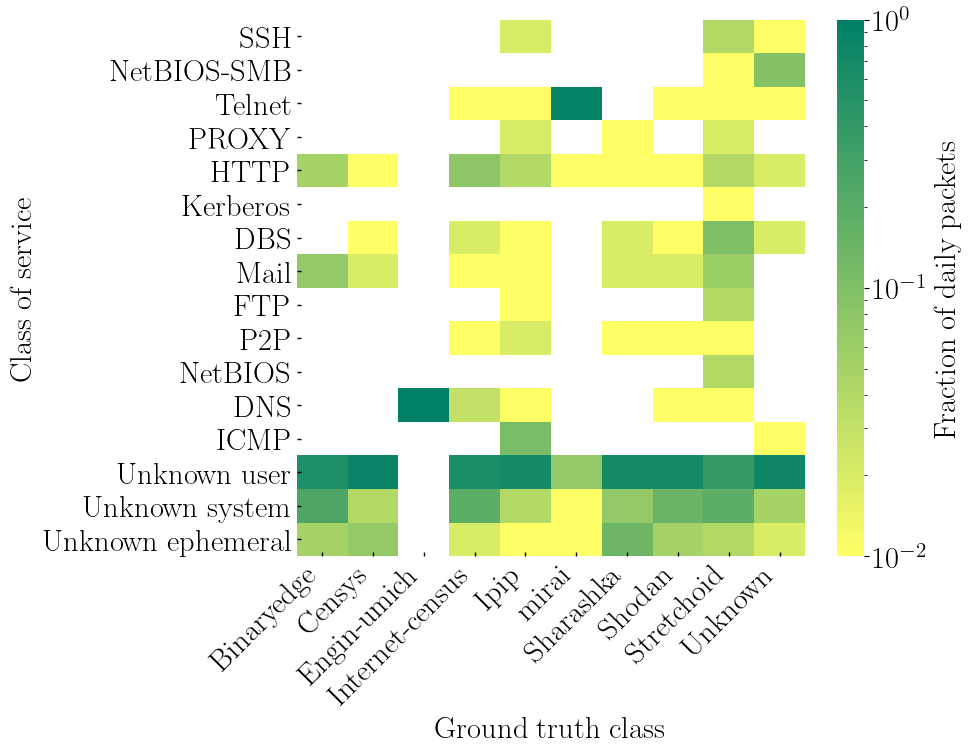

In [11]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: ground_truth_heatmap(plt, pivot),
                     style='latex', figsize=(10, 8), fontsize=22, xticks_rotate=45)
plot.savefig('heatmap_gt_serv.pdf')
plot.show()

___

# <b>Baseline</b>

As a very simple approach let's consider the last day of traffic. After the filtering, 
there are`G = g + 1` classes, where `g` are the ground truth classes and `G` is the number of
classes plus the `unknown`.

Assuming a port-based classifier as a baseline, we define `G`, features. Each one is the fraction
of daily packets sent to each top port.

In [12]:
with open(f'{DATA}/services/services.json', 'r') as file:
    services = json.loads(file.read())

In [13]:
# Load the last-day unfiltered
df = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
# Load the filters
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())
# Apply the 30 days filter
df = df[df.ip.isin(set(filters['d1_f30']))]
#df = df[['ip','port', 'class', 'pp']].drop_duplicates()
# Convert poirt/procol pairs to lowercase
df.pp = df.pp.apply(lambda x: x.lower())
# Get the class of services
df['serv'] = df.pp.apply(lambda x: convert_pp(x, services))
# Add a ones column for packets sum
df['pkts'] = 1

df.head()

,ts,ip,port,proto,pp,class,serv,pkts
0,2021-03-31 08:29:08.449076,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
1,2021-03-31 08:29:08.449088,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
2,2021-03-31 08:29:08.451478,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
3,2021-03-31 08:29:08.451491,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
4,2021-03-31 08:29:08.459322,172.245.10.231,3956,TCP,3956/tcp,unknown,unk_usr,1


In [14]:
# Get the top-ports by classes
temp = df.copy()

rows = []
temp = temp.groupby(['class', 'pp']).agg({'pkts':sum}).reset_index()
for c in temp['class'].unique():
    temp_ = temp[temp['class'] == c]
    top = temp_.sort_values('pkts', ascending=False)
    top_port = top.pp.values[0]
    top_pkts = top.pkts.values[0]
    rows.append((c, top_port, top_pkts))
    
features = pd.DataFrame(rows)[1].unique()

In [15]:
# Build the dataset as the fraction of daily packets per top-8 ports
pivot = df.pivot_table(values='pkts', index='ip', columns='pp', aggfunc='sum')\
          .reindex(columns=features).fillna(.0)
dataset = pivot.to_numpy()/df.groupby('ip').agg({'pkts':'sum'}).to_numpy()
dataset = pd.DataFrame(dataset, columns=pivot.columns, index=pivot.index)
dataset = dataset.reset_index()\
                 .merge(df[['ip', 'class']].drop_duplicates(), on='ip')\
                 .set_index('ip')

dataset.head()

,15/tcp,5060/tcp,53/udp,23/tcp,5986/tcp,2000/tcp,22/tcp,445/tcp,class
ip,,,,,,,,,
1.11.45.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai
1.14.136.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.14.141.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.15.103.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.15.138.147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,mirai


## <b>k-nearest-neighbors Classifier</b>

In [16]:
def knn_step(dataset, k_, with_unknown=False):
    # Run the kNN classifier
    X_train, y_train, X_test, y_test = split_train_test(dataset, with_unknown=with_unknown)
    y_true = y_test
    y_pred = fit_predict(X_train, y_train, X_test, y_test, k_ = k_)

    out = report(y_true, y_pred, output_dict=True)
    
    _out = []
    for k,v in out.items():
        if k not in ['weighted avg', 'macro avg', 'accuracy', 'n.a.']:
            _out.append((out[k]['precision'], k, 'precision'))
            _out.append((out[k]['recall'], k, 'recall'))

    df_step = pd.DataFrame(_out, columns=['val', 'class', 'metric'])
    
    return df_step

In [17]:
res = pd.concat(knn_step(dataset, k, with_unknown=True) for k in range(2, 11))
res.metric = res.metric.apply(lambda x: x.capitalize())

res.head()

,val,class,metric
0,0.000000,binaryedge,Precision
1,0.000000,binaryedge,Recall
2,0.685393,censys,Precision
3,0.181548,censys,Recall
4,0.000000,engin-umich,Precision


<Figure size 640x480 with 0 Axes>

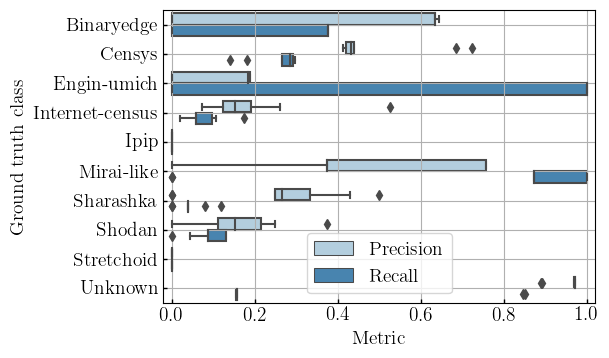

In [18]:
%matplotlib inline
plot = fastplot.plot(None, None, mode = 'callback', callback = lambda plt: knn_boxplot(plt, res),
              style='latex', cycler=cc, figsize=(6.3, 3.8), fontsize=14);
plot.savefig('baseline-knn.pdf')
plot.show()

## <b>k-Means</b>

In [19]:
from sklearn.cluster import KMeans

In [20]:
# Run the kNN classifier
X_train, y_train, X_test, y_test = split_train_test(dataset, with_unknown=True)
y_true = y_test
kmeans = KMeans(n_clusters=len(set(y_true)), random_state=15, n_jobs=-1, algorithm='auto')
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)

In [21]:
dataset['cluster'] = [f'C{c}' for c in y_pred]
dataset.head()

,15/tcp,5060/tcp,53/udp,23/tcp,5986/tcp,2000/tcp,22/tcp,445/tcp,class,cluster
ip,,,,,,,,,,
1.11.45.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai,C1
1.14.136.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.14.141.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.15.103.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.15.138.147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,mirai,C0


In [22]:
temp = dataset.copy()
temp['cnt'] = 1
pivot = temp.pivot_table(values = 'cnt', index='class', 
                         columns='cluster', aggfunc='sum')
pivot = pivot.divide(pivot.sum(1), 'rows')*100

pivot

cluster,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
class,,,,,,,,,,
binaryedge,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
censys,NaN,86.309524,4.761905,NaN,NaN,7.440476,NaN,NaN,0.297619,1.190476
engin-umich,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN
internet-census,NaN,93.203883,NaN,NaN,NaN,4.854369,0.970874,NaN,0.970874,NaN
ipip,2.040816,89.795918,NaN,4.081633,NaN,2.040816,2.040816,NaN,NaN,NaN
mirai,73.404979,12.705754,NaN,0.013604,4.353149,NaN,NaN,8.543055,NaN,0.979459
sharashka,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shodan,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stretchoid,NaN,93.269231,0.961538,3.846154,0.961538,NaN,0.961538,NaN,NaN,NaN


<Figure size 640x480 with 0 Axes>

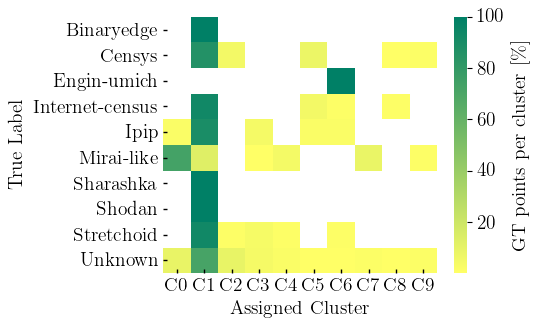

In [23]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: clustering_baseline(plt, pivot),
                     style='latex', figsize=(5.5, 3.5), fontsize=14)
plot.savefig('baseline_clusters.pdf')
plot.show()